In [37]:
!pip install transformers==4.8.1 timm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 13.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 21.6 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.0 MB/s eta 0:00:0000:0100:01
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=4b5c64523b1ec7918b658d4a80910eb90eb99450cdea3ba0511c3320a08292d1
  Stored in directory: /Users/tejasrikurapati/Library/Caches/pip/wheels/12/1c/3d/46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built sacremoses
  Attempting uninstall: tokenizers
    Found exis

In [59]:
import json
import sys
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModel, AutoTokenizer, get_scheduler
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from tqdm.notebook import tqdm, trange
from time import perf_counter
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from random import randint
from urllib.request import urlretrieve

import torch.nn as nn
from torchvision.models.resnet import resnet50

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import numpy as np
import random

def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

In [4]:
seed_val = 0
set_seed(seed_val)

In [6]:
HOME_FOLDER = 'KDD/' # if not mounted
WEBVISION_DATA_FOLDER = HOME_FOLDER + 'webvision_data/'
IMAGE_FOLDER = WEBVISION_DATA_FOLDER + 'images/'
RESULTS_FOLDER = HOME_FOLDER + 'results/'
TRAINED_MODELS_FOLDER = HOME_FOLDER + 'trained_models/'
os.makedirs(RESULTS_FOLDER, exist_ok=True)

In [ ]:
# !mkdir -p $WEBVISION_DATA_FOLDER
# !wget "https://drive.google.com/uc?id=1r4aTTbLuYgGrgpZLOgUH9sQ33DBsbOFm&export=download" -O $WEBVISION_DATA_FOLDER/data.zip
# !unzip $WEBVISION_DATA_FOLDER/data.zip -d $WEBVISION_DATA_FOLDER

In [7]:
df_train = pd.read_csv(WEBVISION_DATA_FOLDER + 'train.csv')
df_test = pd.read_csv(WEBVISION_DATA_FOLDER + 'test.csv')

In [8]:
def show_sample(row_num):
    sample_row = df_train.iloc[row_num]
    print('Index:', row_num)
    print('Label:', sample_row['label'])
    print('Text:', sample_row['text'])
    image_path = IMAGE_FOLDER + sample_row['img_path']
    im = Image.open(image_path)
    plt.imshow(im)

Index: 394
Label: bookshop
Text: The highest forms of literature were to be found on the English bookstall. Perhaps these should be in the Self-Help section .


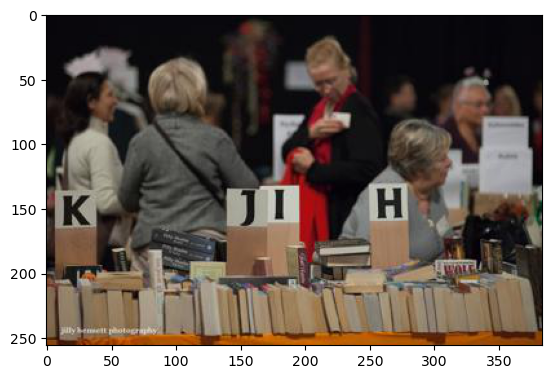

In [9]:
show_sample(randint(0, len(df_train)))

In [10]:
label_to_id = {lab:i for i, lab in enumerate(df_train['label'].sort_values().unique())} #sort values sorts according to alphabets and unique 
id_to_label = {v:k for k,v in label_to_id.items()}

In [11]:
label_to_id

{'bookshop': 0,
 'breakwater': 1,
 'chiton': 2,
 'coil': 3,
 'confectionery': 4,
 'gar': 5,
 'gasmask': 6,
 'polecat': 7,
 'seashore': 8,
 'streetcar': 9}

In [12]:
id_to_label

{0: 'bookshop',
 1: 'breakwater',
 2: 'chiton',
 3: 'coil',
 4: 'confectionery',
 5: 'gar',
 6: 'gasmask',
 7: 'polecat',
 8: 'seashore',
 9: 'streetcar'}

In [13]:
num_out_labels = len(label_to_id)

In [14]:
num_train_epochs = 20 
batch_size = 16
learning_rate = 1.0e-5
weight_decay = 0.01
warmup_steps = 0
max_seq_len = 64

In [17]:
class TextDataset(Dataset):
    def __init__(self, df, label_to_id, text_field = "text", label_field = "label"):
        self.df = df.reset_index(drop = True)
        self.label_to_id = label_to_id
        self.text_field = text_field
        self.label_field = label_field
    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.label_to_id[self.df.at[index, self.label_field]]
        return text, label
    def __len__(self):
        return self.df.shape[0]

bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

class VLBertModel(nn.Module):
    def __init__(self, num_labels, text_pretrained='bert_base_uncased'):
        super().__init__()
        self.num_labels = num_labels
        self.text_encoder = AutoModel.from_pretrained(text_pretrained)
        self.classifier = nn.Linear(
            self.text_encoder.config.hidden_size, num_labels)

    def forward(self, text):
        output = self.text_encoder(text.input_ids, attention_mask=text.attention_mask, return_dict=True)
        logits = self.classifier(output.last_hidden_state[:, 0, :]) # CLS embedding
        return logits
        

bert_model = VLBertModel(num_labels=num_out_labels, text_pretrained='bert-base-uncased')
bert_model = bert_model.to(device)


set_seed(seed_val)

train_dataset = TextDataset(df=df_train, label_to_id=label_to_id, text_field='text', label_field='label')
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size, 
                    sampler=train_sampler)

t_total = len(train_dataloader) * num_train_epochs

optimizer = AdamW(bert_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

criterion = nn.CrossEntropyLoss()
bert_model.train()

start = perf_counter()
for epoch_num in trange(num_train_epochs, desc='Epochs'):
    epoch_total_loss = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):        
        b_text, b_labels = batch            
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_len,
            return_tensors="pt", padding=True
        )
        
        b_labels = b_labels.to(device)
        b_inputs = b_inputs.to(device)

        bert_model.zero_grad()        
        b_logits = bert_model(text=b_inputs)
        
        loss = criterion(b_logits, b_labels)

        epoch_total_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    avg_loss = epoch_total_loss/len(train_dataloader)


    print('epoch =', epoch_num)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])

end = perf_counter()
bert_training_time = end- start
print('Training completed in ', bert_training_time, 'seconds')

bert_prediction_results = []
test_dataset = TextDataset(df=df_test, label_to_id=label_to_id, text_field='text', label_field='label')
test_sampler = SequentialSampler(test_dataset)        
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size, 
                            sampler=test_sampler)

for batch in tqdm(test_dataloader):
    bert_model.eval()
    b_text, b_labels = batch
    b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_len, return_tensors="pt", padding=True)
    b_labels = b_labels.to(device)
    b_inputs = b_inputs.to(device)
    with torch.no_grad():
        b_logits = bert_model(text=b_inputs)
        b_logits = b_logits.detach().cpu()
    
    bert_prediction_results += torch.argmax(b_logits, dim=-1).tolist()
    
bert_prediction_labels = [id_to_label[p] for p in bert_prediction_results]
bert_class_report = classification_report(df_test['label'], bert_prediction_labels, output_dict=True)
bert_class_report['training_time (seconds)'] = bert_training_time
print(bert_class_report['accuracy'])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 0
    epoch_loss = 113.23112392425537
    avg_epoch_loss = 2.2646224784851072
    learning rate = 9.045084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 1
    epoch_loss = 87.23132860660553
    avg_epoch_loss = 1.7446265721321106
    learning rate = 6.545084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 2
    epoch_loss = 60.55875551700592
    avg_epoch_loss = 1.2111751103401185
    learning rate = 3.4549150281252635e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 3
    epoch_loss = 47.939758360385895
    avg_epoch_loss = 0.9587951672077178
    learning rate = 9.549150281252633e-07


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 4
    epoch_loss = 44.45001721382141
    avg_epoch_loss = 0.8890003442764283
    learning rate = 0.0
Training completed in  609.489719995 seconds


  0%|          | 0/13 [00:00<?, ?it/s]

0.77


In [18]:
class ResNetDataset(Dataset):
    def __init__(self, df, label_to_id, train=False, text_field="text", label_field="label", image_path_field="img_path"):
        self.df = df.reset_index(drop=True)
        self.label_to_id = label_to_id
        self.train = train
        self.text_field = text_field
        self.label_field = label_field
        self.image_path_field = image_path_field
        
        # ResNet-50 settings
        self.img_size = 224
        self.mean, self.std = (
            0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)
        
        self.train_transform_func = transforms.Compose(
                [transforms.RandomResizedCrop(self.img_size, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])
        
        self.eval_transform_func = transforms.Compose(
                [transforms.Resize(256),
                    transforms.CenterCrop(self.img_size),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])
        
    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.label_to_id[self.df.at[index, self.label_field]]
        img_path = IMAGE_FOLDER + self.df.at[index, self.image_path_field]
    
        image = Image.open(img_path)
        if self.train:
            img = self.train_transform_func(image)
        else:
            img = self.eval_transform_func(image)
            
        return text, label, img
    
    def __len__(self):
        return self.df.shape[0]
        
        

In [19]:
class ResNetFeatureModel(nn.Module):
    def __init__(self, output_layer):
        super().__init__()
        self.output_layer = output_layer
        pretrained_resnet = resnet50(pretrained=True)
        self.children_list = []
        for n,c in pretrained_resnet.named_children():
            self.children_list.append(c)
            if n == self.output_layer:
                break
        self.net = nn.Sequential(*self.children_list)
        
    def forward(self,x):
        x = self.net(x)
        x = torch.flatten(x, 1)
        return x

In [20]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [23]:
class BertResNetModel(nn.Module):
    def __init__(self, num_labels, text_pretrained='bert-base-uncased'):
        super().__init__()
        self.text_encoder = AutoModel.from_pretrained(text_pretrained)
        self.visual_encoder = ResNetFeatureModel(output_layer='avgpool')
        self.image_hidden_size = 2048
        
        self.classifier = nn.Linear(self.text_encoder.config.hidden_size + self.image_hidden_size, num_labels)
        
    def forward(self, text, image):
        text_output = self.text_encoder(**text)
        text_feature = text_output.last_hidden_state[:, 0, :]
        img_feature = self.visual_encoder(image)
        features = torch.cat((text_feature, img_feature), 1)
        logits = self.classifier(features)
        
        return logits
    
resnet_model = BertResNetModel(num_labels=num_out_labels, text_pretrained='bert-base-uncased')
resnet_model = resnet_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/tejasrikurapati/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the

In [25]:
train_dataset = ResNetDataset(df=df_train, label_to_id=label_to_id, train=True, text_field='text', label_field='label', image_path_field='img_path')
train_sampler = RandomSampler(train_dataset)  
train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size, 
                    sampler=train_sampler)

t_total = len(train_dataloader) * num_train_epochs
optimizer = AdamW(resnet_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

criterion = nn.CrossEntropyLoss()
resnet_model.train()

start = perf_counter()

for epoch_num in trange(num_train_epochs, desc='Epochs'):
    epoch_total_loss = 0
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):        
        b_text, b_labels, b_imgs = batch            
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_len,
            return_tensors="pt", padding=True
        )
        b_labels = b_labels.to(device)
        b_imgs = b_imgs.to(device)
        b_inputs = b_inputs.to(device)
        resnet_model.zero_grad()        
        b_logits = resnet_model(text=b_inputs, image=b_imgs)
        loss = criterion(b_logits, b_labels)
        epoch_total_loss += loss.item()
        loss.backward()
        
        optimizer.step()
        scheduler.step()
    avg_loss = epoch_total_loss/len(train_dataloader)
    
    print('epoch =', epoch_num)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])
end = perf_counter()
resnet_training_time = end- start
print('Training completed in ', resnet_training_time, 'seconds')


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 0
    epoch_loss = 105.06867742538452
    avg_epoch_loss = 2.1013735485076905
    learning rate = 9.045084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 1
    epoch_loss = 73.26008200645447
    avg_epoch_loss = 1.4652016401290893
    learning rate = 6.545084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 2
    epoch_loss = 50.68367689847946
    avg_epoch_loss = 1.0136735379695891
    learning rate = 3.4549150281252635e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 3
    epoch_loss = 40.511503517627716
    avg_epoch_loss = 0.8102300703525543
    learning rate = 9.549150281252633e-07


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 4
    epoch_loss = 37.75633782148361
    avg_epoch_loss = 0.7551267564296722
    learning rate = 0.0
Training completed in  1414.0776016139998 seconds


In [27]:
resnet_prediction_results = []

test_dataset = ResNetDataset(df=df_test, label_to_id=label_to_id, train=False, text_field='text', label_field='label', image_path_field='img_path')
test_sampler = SequentialSampler(test_dataset)        
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size, 
                            sampler=test_sampler)

for batch in tqdm(test_dataloader):
    resnet_model.eval()
    b_text, b_labels, b_imgs = batch
    
    b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_len, return_tensors="pt", padding=True)
    b_labels = b_labels.to(device)
    b_imgs = b_imgs.to(device)
    b_inputs = b_inputs.to(device)
    
    with torch.no_grad():
        b_logits = resnet_model(text=b_inputs, image=b_imgs)
        b_logits = b_logits.detach().cpu()
        
    resnet_prediction_results += torch.argmax(b_logits, dim=-1).tolist()
    
resnet_prediction_labels = [id_to_label[p] for p in resnet_prediction_results]


  0%|          | 0/13 [00:00<?, ?it/s]

In [28]:
resnet_class_report = classification_report(df_test['label'], resnet_prediction_labels, output_dict=True)
resnet_class_report['training_time (seconds)'] = resnet_training_time

with open(RESULTS_FOLDER + 'resnet_class_report.json', 'w') as f:
    json.dump(resnet_class_report, f)
    
print(resnet_class_report['accuracy'])

0.835


In [29]:
ALBEF_FOLDER = HOME_FOLDER + 'ALBEF/'
os.makedirs(ALBEF_FOLDER, exist_ok=True)

In [30]:
!wget https://raw.githubusercontent.com/salesforce/ALBEF/main/models/vit.py -O $ALBEF_FOLDER/vit.py
!wget https://raw.githubusercontent.com/salesforce/ALBEF/main/models/tokenization_bert.py -O $ALBEF_FOLDER/tokenization_bert.py
!wget https://raw.githubusercontent.com/salesforce/ALBEF/main/models/xbert.py -O $ALBEF_FOLDER/xbert.py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
--2023-06-01 14:55:24--  https://raw.githubusercontent.com/salesforce/ALBEF/main/models/vit.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8558 (8.4K) [text/plain]
Saving to: 'KDD/ALBEF//vit.py'

KDD/ALBEF//vit.py   100%[===================>]   8.36K  --.-KB/s    in 0s      

2023-06-01 14:55:25 (33.7 MB/s) - 'KDD/ALBEF//vit.py' saved [8558/8558]

huggingface/tokenizers: The current process just got forked, after paralle

In [48]:
!sed -i 's/processor_class/g' $ALBEF_FOLDER/xbert.py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
sed: 1: "KDD/ALBEF//xbert.py": invalid command code K


In [53]:
sys.path.append(ALBEF_FOLDER)

In [55]:
from vit import VisionTransformer
from xbert import BertConfig as AlbefBertConfig, BertModel as AlbefBertModel
from functools import partial

In [56]:
class AlbefDataset(Dataset):
    def __init__(self, df, label_to_id, train=False, text_field="text", label_field="label", image_path_field="img_path"):
        self.df = df.reset_index(drop=True)
        self.label_to_id = label_to_id
        self.train = train
        self.text_field = text_field
        self.label_field = label_field
        self.image_path_field = image_path_field
        
        self.img_size = 256
        self.mean, self.std = (
            0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)
        
        self.train_transform_func = transforms.Compose(
                [transforms.RandomResizedCrop(self.img_size, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])
        
        self.eval_transform_func = transforms.Compose(
                [transforms.Resize(256),
                    transforms.CenterCrop(self.img_size),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])
    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.label_to_id[self.df.at[index, self.label_field]]
        img_path = IMAGE_FOLDER + self.df.at[index, self.image_path_field]
        image = Image.open(img_path)
        if self.train:
            img = self.train_transform_func(image)
        else:
            img = self.eval_transform_func(image)
        
        return text, label, img
    
    def __len__(self):
        return self.df.shape[0]
        
        

In [57]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [58]:
class AlbefModel(nn.Module):

    def __init__(self, bert_config, num_labels, text_pretrained='bert-base-uncased'):
        super().__init__()

        self.num_labels = num_labels
        self.text_encoder = AlbefBertModel.from_pretrained(
            text_pretrained, config=bert_config, add_pooling_layer=False)
        
        self.visual_encoder = VisionTransformer(
            img_size=256, patch_size=16, embed_dim=768, depth=12, num_heads=12,
            mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))
        
        self.classifier = nn.Linear(
            self.text_encoder.config.hidden_size, num_labels)
    
    def forward(self, text, image):
        image_embeds = self.visual_encoder(image)
        image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long).to(image_embeds.device)
        output = self.text_encoder(text.input_ids, attention_mask=text.attention_mask,
                                   encoder_hidden_states=image_embeds, encoder_attention_mask=image_atts, return_dict=True
                                   )
        logits = self.classifier(output.last_hidden_state[:, 0, :])
        return logits
    

In [61]:
def load_albef_pretrained(num_out_labels):
    tmp_directory = './tmp/albef'
    os.makedirs(tmp_directory, exist_ok=True)
    albef_bert_config_fp = os.path.join(tmp_directory, 'config_bert.json')
    albef_model_fp = os.path.join(tmp_directory, 'ALBEF.pth')
    
    if not os.path.exists(albef_bert_config_fp):
        urlretrieve("https://raw.githubusercontent.com/salesforce/ALBEF/main/configs/config_bert.json", albef_bert_config_fp)
    if not os.path.exists(albef_model_fp):
        urlretrieve("https://storage.googleapis.com/sfr-pcl-data-research/ALBEF/ALBEF_4M.pth", albef_model_fp)
    
    albef_bert_config = AlbefBertConfig.from_json_file(albef_bert_config_fp)
    albef_model = AlbefModel(bert_config=albef_bert_config, num_labels=num_out_labels)
    
    albef_checkpoint = torch.load(albef_model_fp, map_location='cpu')
    albef_state_dict = albef_checkpoint['model']
    
    for key in list(albef_state_dict.keys()):
        if 'bert' in key:
            encoder_key = key.replace('bert.', '')
            albef_state_dict[encoder_key] = albef_state_dict[key]
            del albef_state_dict[key]
            
    msg = albef_model.load_state_dict(albef_state_dict, strict=False)
    print("ALBEF checkpoint loaded from ", albef_model_fp)
    
    print(msg)
    return albef_model

albef_model = load_albef_pretrained(num_out_labels=num_out_labels)
albef_model = albef_model.to(device)
    

ALBEF checkpoint loaded from  ./tmp/albef/ALBEF.pth
_IncompatibleKeys(missing_keys=['classifier.weight', 'classifier.bias'], unexpected_keys=['temp', 'image_queue', 'text_queue', 'queue_ptr', 'vision_proj.weight', 'vision_proj.bias', 'text_proj.weight', 'text_proj.bias', 'itm_head.weight', 'itm_head.bias', 'visual_encoder_m.cls_token', 'visual_encoder_m.pos_embed', 'visual_encoder_m.patch_embed.proj.weight', 'visual_encoder_m.patch_embed.proj.bias', 'visual_encoder_m.blocks.0.norm1.weight', 'visual_encoder_m.blocks.0.norm1.bias', 'visual_encoder_m.blocks.0.attn.qkv.weight', 'visual_encoder_m.blocks.0.attn.qkv.bias', 'visual_encoder_m.blocks.0.attn.proj.weight', 'visual_encoder_m.blocks.0.attn.proj.bias', 'visual_encoder_m.blocks.0.norm2.weight', 'visual_encoder_m.blocks.0.norm2.bias', 'visual_encoder_m.blocks.0.mlp.fc1.weight', 'visual_encoder_m.blocks.0.mlp.fc1.bias', 'visual_encoder_m.blocks.0.mlp.fc2.weight', 'visual_encoder_m.blocks.0.mlp.fc2.bias', 'visual_encoder_m.blocks.1.norm1

In [62]:
set_seed(seed_val)

train_dataset = AlbefDataset(df=df_train, label_to_id=label_to_id, train=True, text_field='text', label_field='label', image_path_field='img_path')
train_sampler = RandomSampler(train_dataset) 

train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size, 
                    sampler=train_sampler)

t_total = len(train_dataloader) * num_train_epochs

optimizer = AdamW(albef_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

criterion = nn.CrossEntropyLoss()

albef_model.train()

start = perf_counter()
for epoch_num in trange(num_train_epochs, desc='Epochs'):
    epoch_total_loss = 0
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):        
        b_text, b_labels, b_imgs = batch            
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_len,
            return_tensors="pt", padding=True
        )
        b_labels = b_labels.to(device)
        b_imgs = b_imgs.to(device)
        b_inputs = b_inputs.to(device)
        albef_model.zero_grad()        
        b_logits = albef_model(text=b_inputs, image=b_imgs)
        loss = criterion(b_logits, b_labels)
        epoch_total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    
    avg_loss = epoch_total_loss/len(train_dataloader)
    print('epoch =', epoch_num)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])
    
end = perf_counter()
albef_training_time = end- start
print('Training completed in ', albef_training_time, 'seconds')


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 0
    epoch_loss = 106.41362392902374
    avg_epoch_loss = 2.1282724785804747
    learning rate = 9.045084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 1
    epoch_loss = 74.11261129379272
    avg_epoch_loss = 1.4822522258758546
    learning rate = 6.545084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 2
    epoch_loss = 51.23491811752319
    avg_epoch_loss = 1.024698362350464
    learning rate = 3.4549150281252635e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 3
    epoch_loss = 41.06350612640381
    avg_epoch_loss = 0.8212701225280762
    learning rate = 9.549150281252633e-07


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 4
    epoch_loss = 37.761055797338486
    avg_epoch_loss = 0.7552211159467697
    learning rate = 0.0
Training completed in  4066.0955574709988 seconds


In [63]:
albef_prediction_results = []
test_dataset = AlbefDataset(df=df_test, label_to_id=label_to_id, train=False, text_field='text', label_field='label', image_path_field='img_path')
test_sampler = SequentialSampler(test_dataset) 

test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size, 
                            sampler=test_sampler)

for batch in tqdm(test_dataloader):
    albef_model.eval()
    b_text, b_labels, b_imgs = batch
    
    b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_len, return_tensors="pt", padding=True)
    
    b_labels = b_labels.to(device)
    b_imgs = b_imgs.to(device)
    b_inputs = b_inputs.to(device)
    
    with torch.no_grad():
        b_logits = albef_model(text=b_inputs, image=b_imgs)
        b_logits = b_logits.detach().cpu()
        
    albef_prediction_results += torch.argmax(b_logits, dim=-1).tolist()

albef_prediction_labels = [id_to_label[p] for p in albef_prediction_results]


  0%|          | 0/13 [00:00<?, ?it/s]

In [64]:
albef_class_report = classification_report(df_test['label'], albef_prediction_labels, output_dict=True)
albef_class_report['training_time (seconds)'] = albef_training_time

with open(RESULTS_FOLDER + 'albef_class_report.json', 'w') as f:
    json.dump(albef_class_report, f)

print(albef_class_report['accuracy'])

0.82


In [ ]:
bert_model.num_labels